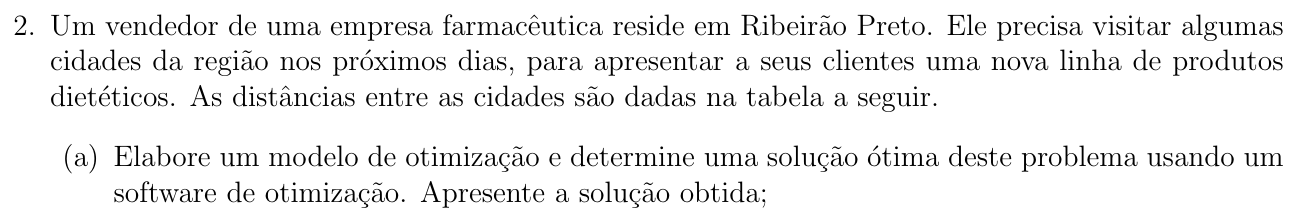

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/2a.png')

In [1]:
# Bibliotecas
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import xlwings as xw
import pandas as pd

In [2]:
# Dados
wb = xw.Book('dados_1.xlsx')
sheet = wb.sheets['Plan2']

# Conjuntos:
Cidades =sheet.range('C2:K2').value
n = len(Cidades)

# Parâmetros
distancia = sheet.range('B2:K11').options(pd.DataFrame).value.stack().to_dict()

In [3]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.C = Set(initialize=Cidades)
C = model.C

# Parâmetros
model.d = Param(C * C, initialize=distancia, within=NonNegativeReals)
d = model.d

# Variáveis de decisão
model.x = Var(C * C, within=Binary)
model.u = Var(C, within=NonNegativeReals)
x, u = model.x, model.u

# Função objetivo
model.obj = Objective(expr=sum(sum(d[i, j] * x[i, j] for j in C if i != j) for i in C))

# Restrições
# Uma cidade visitada por vez
model.r_visita = ConstraintList()
for i in C:
    model.r_visita.add(expr=sum(x[i, j] for j in C if j != i) == 1)
# Cada cidade tem uma única antecessora
model.r_antecessora = ConstraintList()
for j in C:
    model.r_antecessora.add(expr=sum(x[i, j] for i in C if i != j) == 1)
# Formulação de TMZ
model.r_TMZ = ConstraintList()
model.r_TMZ.add(expr=u[1] == 0)
for i in C:
    for j in C:
        if i != j and j > 1:
            model.r_TMZ.add(expr=u[j] >= u[i] + x[i, j] - 10000 * (1 - x[i, j]))

In [4]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [5]:
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in C:
        for j in C:
            if (i != j) and (value(x[i, j]) == 1):
                print(f'O vendedor vai da cidade {int(i)} para {int(j)}')
    print()
    print(f'A distância mínima obtida foi de {value(model.obj)} km')
else:
     print(resultado.solver.termination_condition)

O vendedor vai da cidade 1 para 3
O vendedor vai da cidade 2 para 8
O vendedor vai da cidade 3 para 2
O vendedor vai da cidade 4 para 9
O vendedor vai da cidade 5 para 1
O vendedor vai da cidade 6 para 5
O vendedor vai da cidade 7 para 6
O vendedor vai da cidade 8 para 4
O vendedor vai da cidade 9 para 7

A distância mínima obtida foi de 1357.9 km
